# Garden map.

Installation:
- Install geopandas using `pip install geopandas contextily`
- Downgrade fiona using `pip install fiona==1.9.6`

See [this post](https://stackoverflow.com/questions/78949093/how-to-resolve-attributeerror-module-fiona-has-no-attribute-path) for the reason. 

#### Permapeople 
https://permapeople.org/my/api_keys
id	5CbMcxq8EnrG	

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import geopandas as gpd
from python import geo_parsers, garden_elements, field_parsers, ranging_correction
import contextily as cx
from shapely.geometry import Point

from inference import simple_kalman as kf

crs  WGS84


## Get kadaster coordinates

Use data downloaded from pdoc.

Get:
- `db_info_percelen` List with properties of each kadaster entry. Only geometry is the midpoint of each kadaster entry.
- `gdf` List with geometries (outlines) of each kadaster field.

Both are converted to crs of choice, default Amersfoort EPSG:28992.

[soort grootte](http://brk.basisregistraties.overheid.nl/id/concept/SoortGrootte): of het vastegesteld is of niet.

In [4]:
# Get list of kadaser objects with generic properies and center point.
db_info_percelen = geo_parsers.get_kadaster_objects(kadastrale_object_ids=geo_parsers.kadastrale_object_ids_own,
                                                file_path = r"./datasets/kadastralekaart_perceel.gml")

In [ ]:
# Kadaster contours.
gdf_kadaster = [geo_parsers.get_perceel_coordinates(id, as_polygon=False, file_path=r"./datasets/kadastralekaart_kadastralegrens.gml",) for id in db_info_percelen.index]
gdf_kadaster = gpd.GeoDataFrame( pd.concat( gdf_kadaster, ignore_index=False) )
p_origin = geo_parsers.get_lower_left_point_in_veelerveen_rotation(gdf_kadaster) # Geoseries.

EPSG:28992


## Change to 'Veelerveen coordinates'.
Origin at lower left hand corner, in meters, such that the north side of the land border is horizontal.

In [ ]:
# Create Veelerveen crs
lat_min = p_origin.to_crs('WGS84').get_coordinates().y.min()
lon_min = p_origin.to_crs('WGS84').get_coordinates().x.min()
crs_veelerveen = geo_parsers.get_crs_veeleerveen(lat_min, lon_min)

pyproj.crs.crs.CRS

In [8]:
# Convert both kadaster outlines and kadaset database to veelerveen coordinates.
gdf_kadaster = gdf_kadaster.to_crs(crs_veelerveen)
db_info_percelen = db_info_percelen.to_crs(crs_veelerveen)

## Add trees and ditches.

In [ ]:
# Define origin of orchard as interesting point.
p_origin_orchard = geo_parsers.get_lower_left_point_in_veelerveen_rotation(gdf_kadaster).get_coordinates().iloc[0].values + np.asarray([74, 2])
p_origin_orchard = gpd.GeoSeries(data=Point(*p_origin_orchard), index=['origin_orchard',], crs=crs_veelerveen)

+proj=omerc +lat_0=53.057737974045665 +lonc=7.120513314950779 +alpha=-21 +k=1 +x_0=0 +y_0=0 +gamma=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +type=crs
[73.9996065   1.99961984]


In [12]:
gdf_ditch = garden_elements.get_veelerveen_ditches()

In [142]:
# GPS scan of trees.
gdf_trees = field_parsers.read_gps_coordinates_recorded_with_app(fname = 'datasets/boomgaard_plant_coordinaten/20251005-091825.kml', 
                                                                 crs_veelerveen=crs_veelerveen)

gdf_trees = field_parsers.add_row_to_tree_list(gdf_trees, kind='Corner', new_id=None, base_id=5, replace=True)
gdf_trees = field_parsers.add_row_to_tree_list(gdf_trees, kind='Tamme kastagne', px=110, new_id=None, base_id=15, replace=False)


gdf_trees['label'] = gdf_trees.apply(lambda row: f'{row.name}_{row.kind}', axis=1)
gdf_trees


Wrote 19 tree entries to ./data_cache/examples_gdf_trees.toml


,kind,geometry,label
0,Corner,POINT Z (75.714 3.8 44.669),0_Corner
1,Wilg,POINT Z (81.866 5.757 43.57),1_Wilg
2,Wilg,POINT Z (80.858 10.782 43.231),2_Wilg
3,Wilg,POINT Z (81.387 14.67 43.239),3_Wilg
4,Wilg,POINT Z (81.117 19.882 42.943),4_Wilg
5,Corner,POINT Z (77.107 22.58 43.131),5_Corner
6,Fruit,POINT Z (84.223 17.943 43.101),6_Fruit
7,Fruit,POINT Z (83.583 13.57 43.671),7_Fruit
8,Hole,POINT Z (87.143 13.163 45.46),8_Hole
9,Appelboom,POINT Z (88.328 14.705 45.271),9_Appelboom


In [139]:
# ranging_correction.measurements

## Plotting

In [ ]:
# North annotation


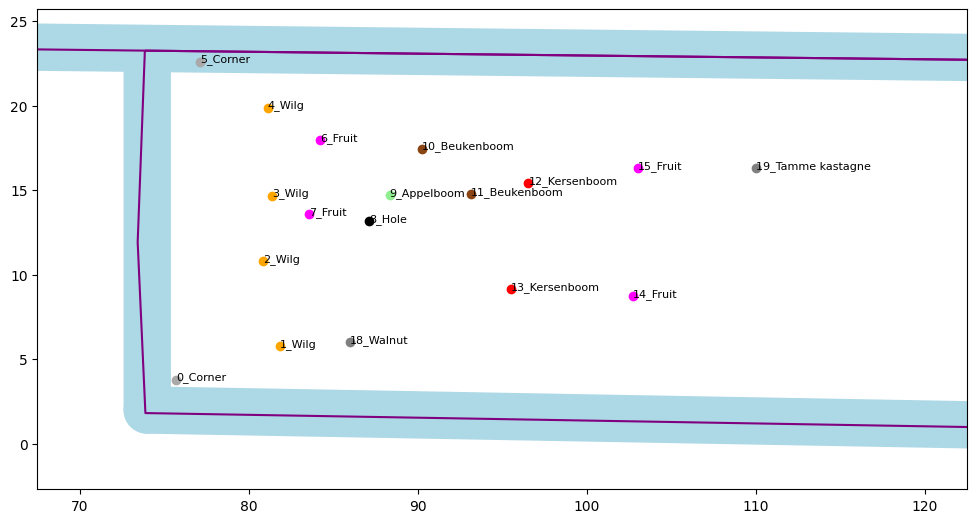

In [144]:
def plot_orchard(gdf_kadaster, db_info_percelen, gdf_trees):
    _, ax = plt.subplots(1,1, figsize=(12, 8), squeeze=True)

    gdf_north = geo_parsers.get_north_arrow(crs_veelerveen, p_shift_x=0, p_shift_y=0)
    gdf_north.plot(ax=ax, linewidth=4, color='k')

    ax = gdf_kadaster.plot(color='purple', edgecolor="black", alpha=1, ax=ax)
    ax = db_info_percelen.plot(color='orange', edgecolor="black", alpha=1, ax=ax, markersize=30)
    # cx.add_basemap(ax, crs=gdf_kadaster.crs, alpha=.6)
    geo_parsers.add_label_annotation_to_map(ax, db_info_percelen)

    gdf_ditch.plot(ax=ax, color='lightblue')

    for label, df_group in gdf_trees.groupby('kind'):
        color = garden_elements.element_colors.get(label, 'grey')
        df_group.plot(ax=ax, color=color)
    geo_parsers.add_label_annotation_to_map(ax, gdf_trees, fontweight='normal', fontsize=8, horizontalalignment='left', row_label='label')

    # p_origin.to_crs(crs_veelerveen).plot(ax=ax, color='black', markersize=100)

    # p_origin_orchard.plot(ax=ax, color='black', markersize=100)
    ax.set_ylim(-2, 25)
    # ax.set_xlim(70, 180)
    ax.set_xlim(70, 120)
    ax.set_aspect('equal')

    garden_elements.widen_map_plot(ax, percentage_x=0.1, percentage_y=0.051)
    return ax

ax = plot_orchard(gdf_kadaster, db_info_percelen, gdf_trees)


$J(x_0) = \begin{bmatrix} 2r_0^\top & -2r_0^\top \end{bmatrix} \in \mathbb{R}^{1\times 4}$


In [ ]:


# C = np.zeros((len(measurements), n_states))
# y = np.zeros(len(measurements))
# R = np.eye(len(measurements))

# for i, measurement in enumerate(measurements):
#     i_A, i_B, d, sd_d = measurement['distance']
#     indices_A = state_indices[i_A]
#     indices_B = state_indices[i_B]

#     r0 = x[indices_A] - x[indices_B]

#     C[i, indices_A] = 2*r0
#     C[i, indices_B] = -2*r0
    
#     y[i] = d**2 - np.dot(r0, r0) + C[i,:] @ x
#     R[i,i] = sd_d**2

#     x, Px = kf.update(x, Px, y, C, R)


# # Put back in geodataframe
# for label, state_index in state_indices.items():
#     index = gdf_trees[gdf_trees.label==label].index[0]
#     gdf_trees.at[index, 'geometry'] = Point(x[state_index[0]], x[state_index[1]])